In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import seaborn as sns
import sqlite3
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import numpy as np
from sklearn.metrics import mean_squared_error
from math import sqrt
import RebapCalc

In [2]:
cnx = sqlite3.connect('Prognosedaten.db')
strSQL = 'SELECT * from GridLoad,Rebap, SRL, MRL,Intraday, NRV, RE, SpotMarket WHERE SRL.SRL_DateTime = RE.RE_DateTime AND SRL.SRL_DateTime = GridLoad.GridLoad_DateTime AND SRL.SRL_DateTime = Rebap.Rebap_DateTime AND SRL.SRL_DateTime = MRL.MRL_DateTime AND SRL.SRL_DateTime = Intraday.Intraday_DateTime AND SRL.SRL_DateTime = NRV.NRV_DateTime AND SRL.SRL_DateTime = SpotMarket.Spot_DateTime AND SRL.SRL_AbgerMenge_Pos <> "-" AND SRL.SRL_AbgerMenge_Neg <> "-" AND SRL.SRL_Leistungspreis_Neg <> "-" AND SRL.SRL_Leistungspreis_POS <> "-" AND MRL_DateTime NOT LIKE "%2018%"'

df = pd.read_sql_query(strSQL,cnx)

df = df.drop("SRL_DateTime",axis=1)
df = df.drop("SRL_Key",axis=1)
df = df.drop("MRL_DateTime",axis=1)
df = df.drop("MRL_Key",axis=1)
df = df.drop("Intraday_DateTime",axis=1)
df = df.drop("Intraday_Key",axis=1)
df = df.drop("NRV_DateTime",axis=1)
df = df.drop("NRV_Key",axis=1)
df = df.drop("Spot_DateTime",axis=1)
df = df.drop("Spot_Key",axis=1)
df = df.drop("RE_DateTime",axis=1)
df = df.drop("RE_Key",axis=1)
df = df.drop("Rebap_DateTime",axis=1)
df = df.drop("Rebap_Key",axis=1)
df = df.drop("GridLoad_DateTime",axis=1)
df = df.drop("GridLoad_Key",axis=1)

#df = df.drop("GridLoad_val",axis=1)
#df = df.drop("SRL_VorgehMenge_Pos",axis=1)
#df = df.drop("SRL_VorgehMenge_Neg",axis=1)
df = df.drop("SRL_Leistungspreis_Pos",axis=1) 
df = df.drop("SRL_Leistungspreis_Neg",axis=1)
#df = df.drop("MRL_VorgehMenge_Pos",axis=1)
#df = df.drop("MRL_VorgehMenge_Neg",axis=1)
df = df.drop("MRL_Leistungspreis_Pos",axis=1)
df = df.drop("MRL_Leistungspreis_Neg",axis=1)
#df = df.drop("Intraday_Preis",axis=1)
#df = df.drop("Intraday_Volumen",axis=1)
#df = df.drop("RE_PV_Ante",axis=1)
#df = df.drop("RE_WI_Ante",axis=1)
#df = df.drop("RE_PV_Post",axis=1) 
#df = df.drop("RE_WI_Post",axis=1)
df = df.drop("Spot_Price",axis=1)
df = df.drop("Spot_Vol",axis=1)
#print(df)


In [3]:
train=df.sample(frac=0.8,random_state=200) #random state is a seed value
test=df.drop(train.index)

rebap_test = (test['Rebap_Preis']).copy().to_numpy()
rebaptemp = test['Rebap_Preis'].copy().to_numpy()

pdY_train = train[['SRL_AbgerMenge_Pos', 'SRL_Arbeitspreis_Pos', 'SRL_AbgerMenge_Neg','SRL_Arbeitspreis_Neg','NRV_Saldo','MRL_AbgerMenge_Pos', 'MRL_Arbeitspreis_Pos', 'MRL_AbgerMenge_Neg','MRL_Arbeitspreis_Neg']].copy()
pdX_train = train.drop(['SRL_AbgerMenge_Pos', 'SRL_Arbeitspreis_Pos', 'SRL_AbgerMenge_Neg','SRL_Arbeitspreis_Neg','NRV_Saldo','MRL_AbgerMenge_Pos', 'MRL_Arbeitspreis_Pos', 'MRL_AbgerMenge_Neg','MRL_Arbeitspreis_Neg','Rebap_Preis'], axis=1)

pdY_test = test[['SRL_AbgerMenge_Pos', 'SRL_Arbeitspreis_Pos', 'SRL_AbgerMenge_Neg','SRL_Arbeitspreis_Neg','NRV_Saldo','MRL_AbgerMenge_Pos', 'MRL_Arbeitspreis_Pos', 'MRL_AbgerMenge_Neg','MRL_Arbeitspreis_Neg']].copy()
pdX_test = test.drop(['SRL_AbgerMenge_Pos', 'SRL_Arbeitspreis_Pos', 'SRL_AbgerMenge_Neg','SRL_Arbeitspreis_Neg','NRV_Saldo','MRL_AbgerMenge_Pos', 'MRL_Arbeitspreis_Pos', 'MRL_AbgerMenge_Neg','MRL_Arbeitspreis_Neg','Rebap_Preis'], axis=1)

AEP4 =  RebapCalc.GetRebap(2000,test['NRV_Saldo'].copy().to_numpy(),test['Intraday_Preis'].copy().to_numpy(),test['SRL_Arbeitspreis_Pos'].copy().to_numpy(),test['MRL_Arbeitspreis_Pos'].copy().to_numpy(),test['SRL_Arbeitspreis_Neg'].copy().to_numpy(),test['MRL_Arbeitspreis_Neg'].copy().to_numpy(),test['SRL_AbgerMenge_Pos'].copy().to_numpy(),test['SRL_AbgerMenge_Neg'].copy().to_numpy(),test['MRL_AbgerMenge_Pos'].copy().to_numpy(),test['MRL_AbgerMenge_Neg'].copy().to_numpy())

#plt.plot(rebap_test,color='red',linewidth=0.07)
#plt.plot(AEP4,color='green',linewidth=0.07)
#rms = sqrt(mean_squared_error(AEP4, rebap_test))
#print("RMS: ")
#print(rms)
#plt.show

Xtrain = pdX_train.to_numpy()
Ytrain = pdY_train.to_numpy()

Xtest  = pdX_test.to_numpy()
Ytest  = pdY_test.to_numpy()

print("Data poccessed starting on the ML stuff")


Data poccessed starting on the ML stuff


In [4]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=20)

In [5]:
def get_model():

	model = tf.keras.Sequential()
	model.add(tf.keras.layers.Dense(20, activation='relu', input_shape=[Xtrain.shape[1]]))
	model.add(keras.layers.Dense(20,    activation='relu'))
	model.add(keras.layers.Dense(20,    activation='relu'))
	model.add(keras.layers.Dense(20,    activation='relu'))
	model.add(keras.layers.Dense(20,    activation='relu'))
	model.add(keras.layers.Dense(20,    activation='relu'))
	model.add(keras.layers.Dense(20,    activation='relu'))
	model.add(keras.layers.Dense(20,    activation='relu'))
	model.add(keras.layers.Dense(10,    activation='relu'))
	model.add(tf.keras.layers.Dense(9))
	
	sgd = tf.optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
	rmspop = tf.keras.optimizers.RMSprop(0.001)#chills at 2.3
	model.compile(optimizer=rmspop,loss='mean_squared_logarithmic_error')
	return model

In [6]:
model = get_model()
_ = model.fit(Xtrain,Ytrain,
	#batch_size=64,
	epochs=100,
	#steps_per_epoch=5,
	#verbose=0,
	validation_data = (Xtest,Ytest))#,
	#callbacks=[callback])
#print(pdX_train)

Epoch 1/100
1864/1864 [==============================] - 5s 3ms/step - loss: 1.9176 - val_loss: 1.7321
Epoch 2/100
1864/1864 [==============================] - 5s 3ms/step - loss: 1.6648 - val_loss: 1.6220
Epoch 3/100
1864/1864 [==============================] - 4s 2ms/step - loss: 1.6149 - val_loss: 1.6181
Epoch 4/100
1864/1864 [==============================] - 4s 2ms/step - loss: 1.6022 - val_loss: 1.6111
Epoch 5/100
1864/1864 [==============================] - 5s 2ms/step - loss: 1.5960 - val_loss: 1.5902
Epoch 6/100
1864/1864 [==============================] - 4s 2ms/step - loss: 1.5931 - val_loss: 1.6574
Epoch 7/100
1864/1864 [==============================] - 5s 3ms/step - loss: 1.5931 - val_loss: 1.5862
Epoch 8/100
1864/1864 [==============================] - 5s 2ms/step - loss: 1.5917 - val_loss: 1.6070
Epoch 9/100
1864/1864 [==============================] - 5s 3ms/step - loss: 1.5856 - val_loss: 1.5866
Epoch 10/100
1864/1864 [==============================] - 5s 3ms/step - l

RMS: 
55.82084366950005


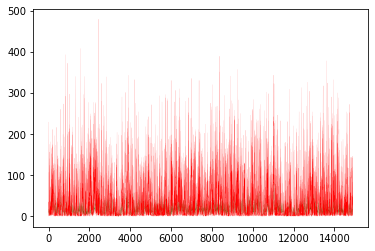

In [8]:
predictions = model.predict(Xtest)


#print(predictions)
rebapPredict = (predictions[:,0]*predictions[:,1]+(-1)*predictions[:,2]*predictions[:,3]+predictions[:,5]*predictions[:,6]+(-1)*predictions[:,7]*predictions[:,8])/predictions[:,4]

rms = sqrt(mean_squared_error(predictions[:,0], Ytest[:,0]))
print("RMS: ")
print(rms)
plt.plot(predictions[:,0],color='green',linewidth=0.07)
plt.plot(Ytest[:,0],color='red',linewidth=0.07)
plt.show()

#rebapPredict = 1*(np.clip(rebapPredict, -1000, 1000))
#plt.plot(rebap_test,color='green',linewidth=0.07)
#plt.plot(rebapPredict,color='red',linewidth=0.07)
#rms = sqrt(mean_squared_error(rebapPredict, rebap_test))
#print("RMS: ")
#print(rms)
#plt.show()